In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import inspect
import sys
# add parent directory to path to be able to load local RLC lib.
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from RLC.move_chess.environment import Board
from RLC.move_chess.agent import Piece
from RLC.move_chess.learn import Reinforce

In [6]:
env = Board()
env.render()
env.visual_board

[['[S]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[ ]'],
 ['[ ]', '[ ]', '[ ]', '[ ]', '[ ]', '[F]', '[ ]', '[ ]']]

In [7]:
p = Piece(piece='king')
r = Reinforce(p,env)

# Reinforcement Learning: 
Markov property: The future is independent of the past given the present.

<div>
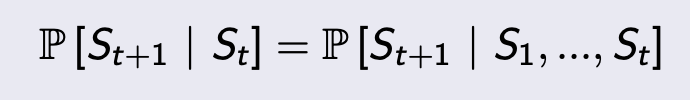
</div>

Goal is to find an optimal policy $\pi^{*}$ that maximizes the expected reward. For this we define a value function as a measure (how good it is to be in a certain state.)

\begin{equation*}
v_{\pi}(s) = \sum_{a} \pi(a | s) q_{\pi} (s,a)
\end{equation*}

\begin{equation*}
q_{\pi}(s, a) = \sum_{s'} P^{a}_{ss'} [R^{a}_{ss'} + \gamma v_{\pi}(s')]
\end{equation*}

with a the action, s the state and s' the successor state. $\pi(s, a)$ is the followed policy, $q_{\pi}(s,a)$ the action-value or Q function, R the reward function and $\gamma$ the discount factor. Discount factor weights off immediate rewards vs long-term rewards (Avoids also infinite returns in cyclic MP). $$P^{a}_{ss'} = P(s' | s, a)$$

There are different methods to find the optimal policy. We will start with the simplest ones.
- value iteration
- policy evaluation
- policy iteration

## Value iteration
Starts from the endpoint and then works backward updating $q^{*}$ or $v^{*}$.

Algorithm:
- initialize    $$v^{*}_{0}(s) = 0 \ \forall s \ except \ termination \ states. $$
- for k = 1 ... K, need to set endpoint K
$$v^{*}_{k+1}(s) = \max_{a} \sum_{s'} P^{a}_{ss'} [R^{a}_{ss'} + \gamma v^{*}_{k}(s')]$$

## Policy evaluation
Calculate value function iteratively until stable using an input policy $\pi(s, a)$.
Algorithm:
- initialize    $$v^{*}_{0}(s) = 0 \ \forall s \ except \ termination \ states. $$
- repeat k (= 0...K)
$\Delta v = 0$

        for each s:
$$v^{*}_{k+1}(s) = \sum_{a} \pi(a | s) \sum_{s'} P^{a}_{ss'} [R^{a}_{ss'} + \gamma v^{*}_{k}(s')] $$
$$ \Delta v = \max (\Delta v, | v^{*}_{k+1}(s) - v^{*}_{k}(s)|)$$
until $\Delta v \le \epsilon$

- optimal policy in each state s is found by taking the action that results in maximal value:
$$\pi^{*} (s) = \arg \max_{a} \sum_{s'} P^{a}_{ss'} [R^{a}_{ss'} + \gamma v^{*}_{K}(s')]$$

## Policy iteration
We evaluate and improve the policy until the policy is stable.
- initialize
- repeat
    - policy evaluation using $\pi^{*}_{k}(a | s)$
    - policy improvement:
    
        for each s:
$$\pi^{*}_{k+1}(s) = \arg \max_{a} \sum_{s'} P^{a}_{ss'} [R^{a}_{ss'} + \gamma v^{*}_{k+1}(s')] $$
until $\pi^{*}_{k+1}(s) = \pi^{*}_{k}(s) \ \forall s$

In General Policy Iteration one maintains both an approximate policy and an approximate value function. The value function is repeatedly altered to more closely approximate the value function for the current policy, and the policy is repeatedly improved with respect to the current value function. These two kinds of changes work against each other to some extent, as each creates a moving target for the other, but together they cause both policy and value function to approach optimality.

## Asynchronous
Can significantly reduce computation and is guaranteed to converge if all states continue to be selected.
- in-place DP:
This mainly means that we already use the updated value of the successor states where possible. (we do not have a copy of the value function)
- Prioritised sweeping: Use magnitude bellman error ($|\Delta|$) to guide state selection. (maintain priority queue)
- real-time DP: only keep states that are relevant to the agent i.e. use agent's experience to guide the selection of states.


In [14]:
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

eps = 0.1
k_max = 1000
value_delta_max = 0
gamma = 1
synchronous = True

value_delta_max = 0
for k in range(k_max):
    r.agent.value_function_prev = r.agent.value_function.copy()  # For synchronous updates
    for row in range(r.agent.value_function.shape[0]):
        for col in range(r.agent.value_function.shape[1]):
            r.agent.value_function[row, col] = r.evaluate_state_no_policy((row, col), gamma=gamma, synchronous=synchronous)
    value_delta = np.max(np.abs(r.agent.value_function_prev - r.agent.value_function))
    value_delta_max = value_delta
    if value_delta_max < eps:
        print('converged at iter',k)
        break
print(r.agent.value_function.astype(int))

converged at iter 7
[[-7 -7 -7 -7 -7 -7 -7 -7]
 [-6 -6 -6 -6 -6 -6 -6 -6]
 [-5 -5 -5 -5 -5 -5 -5 -5]
 [-5 -4 -4 -4 -4 -4 -4 -4]
 [-5 -4 -3 -3 -3 -3 -3 -3]
 [-5 -4 -3 -2 -2 -2 -2 -2]
 [-5 -4 -3 -2 -1 -1 -1 -2]
 [-5 -4 -3 -2 -1  0 -1 -2]]


In [15]:
# set action by value function.
r.improve_policy()
r.visualize_policy()

[['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['→', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↗', '→', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↗', '↗', '→', '↘', '↘', '↘', '↓', '↙'],
 ['↗', '↗', '↗', '→', '↘', '↓', '↙', '↙'],
 ['↗', '↗', '↗', '↗', '→', 'F', '←', '←']]


In [16]:
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

# policy evaluation with random policy (equal prob in all directions).
eps = 0.1
k_max = 1000
value_delta_max = 0
gamma = 1
synchronous = True

for k in range(k_max):
    r.evaluate_policy(gamma=gamma,synchronous=synchronous)
    value_delta_max = np.max(np.abs(r.agent.value_function_prev - r.agent.value_function))
    print(r.agent.value_function.astype(int))
    if value_delta_max < eps:
        print('converged at iter',k)
        break
        


[[-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1 -1 -1 -1]
 [-1 -1 -1 -1 -1  0 -1 -1]]
[[-2 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -2 -2 -2 -2]
 [-2 -2 -2 -2 -1 -1 -1 -2]
 [-2 -2 -2 -2 -1  0 -1 -2]]
[[-3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -3 -3 -3 -3 -3]
 [-3 -3 -3 -2 -2 -2 -2 -2]
 [-3 -3 -3 -2 -2 -2 -2 -2]
 [-3 -3 -3 -2 -2  0 -2 -2]]
[[-4 -4 -4 -4 -4 -4 -4 -4]
 [-4 -4 -4 -4 -4 -4 -4 -4]
 [-4 -4 -4 -4 -4 -4 -4 -4]
 [-4 -4 -4 -4 -4 -4 -4 -4]
 [-4 -4 -3 -3 -3 -3 -3 -3]
 [-4 -4 -3 -3 -3 -3 -3 -3]
 [-4 -4 -3 -3 -3 -3 -3 -3]
 [-4 -4 -3 -3 -3  0 -3 -3]]
[[-5 -5 -5 -5 -5 -5 -5 -5]
 [-5 -5 -5 -5 -5 -5 -5 -5]
 [-5 -5 -5 -5 -5 -5 -5 -5]
 [-5 -4 -4 -4 -4 -4 -4 -4]
 [-5 -4 -4 -4 -4 -4 -4 -

 [-30 -29 -28 -25 -19   0 -17 -21]]
[[-32 -32 -32 -32 -32 -32 -32 -32]
 [-32 -32 -32 -32 -32 -31 -31 -31]
 [-32 -32 -31 -31 -31 -31 -31 -31]
 [-31 -31 -31 -30 -30 -30 -30 -30]
 [-31 -31 -30 -29 -29 -28 -28 -28]
 [-31 -30 -29 -28 -26 -25 -25 -25]
 [-31 -30 -29 -26 -22 -20 -20 -23]
 [-31 -30 -28 -25 -19   0 -18 -21]]
[[-33 -33 -33 -33 -33 -33 -33 -33]
 [-33 -33 -33 -33 -32 -32 -32 -32]
 [-33 -33 -32 -32 -32 -32 -32 -32]
 [-32 -32 -32 -31 -31 -31 -30 -30]
 [-32 -32 -31 -30 -29 -29 -28 -29]
 [-32 -31 -30 -28 -27 -26 -26 -26]
 [-31 -31 -29 -27 -22 -20 -20 -23]
 [-31 -31 -29 -26 -20   0 -18 -22]]
[[-34 -34 -34 -34 -34 -34 -33 -34]
 [-34 -34 -34 -33 -33 -33 -33 -33]
 [-34 -33 -33 -33 -33 -33 -32 -32]
 [-33 -33 -33 -32 -32 -31 -31 -31]
 [-33 -33 -32 -31 -30 -29 -29 -29]
 [-32 -32 -31 -29 -27 -26 -26 -26]
 [-32 -32 -30 -27 -23 -21 -21 -24]
 [-32 -32 -30 -27 -20   0 -18 -22]]
[[-35 -35 -35 -35 -34 -34 -34 -34]
 [-35 -35 -35 -34 -34 -34 -34 -34]
 [-35 -34 -34 -34 -34 -33 -33 -33]
 [-34 -34 -34 -3

 [-54 -53 -50 -44 -33   0 -29 -35]]
[[-60 -60 -60 -59 -59 -59 -58 -59]
 [-60 -60 -59 -59 -58 -58 -58 -58]
 [-59 -59 -58 -57 -57 -56 -56 -56]
 [-58 -58 -57 -56 -54 -54 -53 -53]
 [-57 -56 -55 -53 -51 -49 -49 -49]
 [-56 -55 -53 -49 -46 -43 -43 -43]
 [-55 -54 -51 -46 -37 -34 -34 -38]
 [-55 -54 -50 -44 -33   0 -29 -35]]
[[-61 -61 -61 -60 -60 -59 -59 -59]
 [-61 -60 -60 -59 -59 -59 -58 -58]
 [-60 -60 -59 -58 -57 -57 -57 -57]
 [-59 -58 -57 -56 -55 -54 -54 -54]
 [-58 -57 -56 -54 -52 -50 -49 -49]
 [-57 -56 -53 -50 -46 -44 -43 -44]
 [-56 -55 -52 -47 -38 -34 -34 -38]
 [-56 -54 -51 -45 -34   0 -29 -35]]
[[-62 -62 -61 -61 -60 -60 -60 -60]
 [-62 -61 -61 -60 -60 -59 -59 -59]
 [-61 -60 -60 -59 -58 -58 -57 -57]
 [-60 -59 -58 -57 -56 -55 -54 -54]
 [-58 -58 -56 -54 -52 -51 -50 -50]
 [-57 -56 -54 -51 -47 -44 -44 -44]
 [-57 -55 -52 -47 -38 -34 -34 -39]
 [-56 -55 -52 -45 -34   0 -30 -36]]
[[-63 -63 -62 -62 -61 -61 -61 -61]
 [-62 -62 -62 -61 -60 -60 -60 -60]
 [-62 -61 -60 -60 -59 -58 -58 -58]
 [-60 -60 -59 -5

 [-76 -74 -70 -61 -45   0 -39 -47]]
[[-86 -86 -85 -84 -83 -83 -83 -83]
 [-85 -85 -84 -83 -82 -82 -81 -81]
 [-84 -84 -82 -81 -80 -79 -79 -79]
 [-82 -82 -80 -78 -76 -75 -74 -74]
 [-80 -79 -77 -74 -71 -69 -68 -68]
 [-79 -77 -74 -69 -64 -60 -59 -59]
 [-77 -75 -71 -64 -52 -46 -46 -51]
 [-77 -75 -70 -61 -46   0 -39 -47]]
[[-87 -86 -86 -85 -84 -84 -83 -83]
 [-86 -86 -85 -84 -83 -82 -82 -82]
 [-85 -84 -83 -82 -81 -80 -79 -79]
 [-83 -82 -81 -79 -77 -75 -75 -75]
 [-81 -80 -78 -75 -72 -69 -68 -68]
 [-79 -78 -74 -69 -64 -60 -59 -60]
 [-78 -76 -72 -64 -52 -46 -46 -51]
 [-78 -75 -71 -62 -46   0 -39 -47]]
[[-88 -87 -86 -85 -85 -84 -84 -84]
 [-87 -86 -85 -84 -84 -83 -83 -83]
 [-85 -85 -84 -82 -81 -80 -80 -80]
 [-84 -83 -81 -79 -77 -76 -75 -75]
 [-82 -80 -78 -75 -72 -70 -69 -69]
 [-80 -78 -75 -70 -64 -61 -60 -60]
 [-78 -77 -72 -65 -52 -47 -46 -52]
 [-78 -76 -71 -62 -46   0 -40 -48]]
[[-88 -88 -87 -86 -85 -85 -84 -85]
 [-87 -87 -86 -85 -84 -83 -83 -83]
 [-86 -85 -84 -83 -82 -81 -80 -80]
 [-84 -83 -82 -8

 [ -94  -92  -86  -75  -55    0  -47  -57]]
[[-107 -107 -106 -105 -104 -103 -102 -103]
 [-106 -106 -105 -103 -102 -101 -101 -101]
 [-105 -104 -102 -101  -99  -98  -97  -97]
 [-102 -101  -99  -97  -94  -92  -91  -91]
 [ -99  -98  -95  -91  -87  -85  -83  -83]
 [ -97  -95  -91  -85  -78  -73  -72  -72]
 [ -95  -93  -88  -78  -63  -56  -56  -62]
 [ -95  -92  -86  -75  -56    0  -47  -57]]
[[-108 -107 -106 -105 -104 -103 -103 -103]
 [-107 -106 -105 -104 -103 -102 -101 -101]
 [-105 -104 -103 -101 -100  -98  -98  -97]
 [-103 -102 -100  -97  -95  -93  -92  -92]
 [-100  -98  -96  -92  -88  -85  -83  -83]
 [ -97  -96  -91  -85  -78  -74  -72  -72]
 [ -96  -93  -88  -79  -64  -57  -56  -62]
 [ -95  -93  -87  -76  -56    0  -48  -57]]
[[-108 -108 -107 -106 -105 -104 -103 -104]
 [-107 -107 -106 -104 -103 -102 -102 -102]
 [-106 -105 -103 -102 -100  -99  -98  -98]
 [-103 -102 -100  -98  -95  -93  -92  -92]
 [-100  -99  -96  -92  -88  -85  -84  -84]
 [ -98  -96  -92  -85  -79  -74  -73  -73]
 [ -96  

 [-106 -103  -97  -84  -62    0  -53  -63]]
[[-121 -121 -119 -118 -117 -116 -116 -116]
 [-120 -119 -118 -117 -115 -114 -114 -114]
 [-118 -117 -116 -114 -112 -110 -109 -109]
 [-115 -114 -112 -109 -106 -104 -103 -103]
 [-112 -111 -107 -103  -98  -95  -93  -93]
 [-109 -107 -102  -95  -88  -82  -81  -81]
 [-107 -105  -98  -88  -71  -63  -62  -69]
 [-107 -104  -97  -84  -62    0  -53  -64]]
[[-122 -121 -120 -119 -117 -116 -116 -116]
 [-121 -120 -119 -117 -116 -115 -114 -114]
 [-119 -118 -116 -114 -112 -111 -110 -110]
 [-116 -114 -112 -109 -107 -104 -103 -103]
 [-113 -111 -108 -103  -99  -95  -94  -93]
 [-110 -107 -103  -95  -88  -82  -81  -81]
 [-108 -105  -99  -88  -71  -63  -62  -69]
 [-107 -104  -97  -85  -63    0  -53  -64]]
[[-122 -122 -120 -119 -118 -117 -116 -117]
 [-121 -120 -119 -118 -116 -115 -114 -114]
 [-119 -118 -116 -114 -113 -111 -110 -110]
 [-116 -115 -113 -110 -107 -105 -103 -103]
 [-113 -111 -108 -104  -99  -96  -94  -94]
 [-110 -108 -103  -96  -88  -83  -81  -81]
 [-108 -

[[-134 -133 -132 -130 -129 -128 -127 -127]
 [-132 -131 -130 -128 -127 -126 -125 -125]
 [-130 -129 -127 -125 -123 -121 -120 -120]
 [-127 -125 -123 -120 -117 -114 -113 -113]
 [-123 -121 -118 -113 -108 -104 -102 -102]
 [-120 -118 -112 -104  -96  -90  -88  -88]
 [-118 -115 -108  -97  -78  -69  -68  -76]
 [-117 -114 -106  -93  -68    0  -58  -69]]
[[-134 -133 -132 -130 -129 -128 -127 -128]
 [-133 -132 -130 -129 -127 -126 -125 -125]
 [-130 -129 -128 -125 -123 -121 -121 -120]
 [-127 -126 -123 -120 -117 -115 -113 -113]
 [-124 -122 -118 -113 -108 -105 -103 -102]
 [-120 -118 -113 -105  -96  -90  -88  -89]
 [-118 -115 -108  -97  -78  -69  -68  -76]
 [-118 -114 -107  -93  -69    0  -58  -69]]
[[-135 -134 -132 -131 -129 -128 -128 -128]
 [-133 -132 -131 -129 -128 -126 -126 -126]
 [-131 -130 -128 -126 -124 -122 -121 -121]
 [-128 -126 -124 -121 -117 -115 -113 -113]
 [-124 -122 -118 -114 -109 -105 -103 -103]
 [-121 -118 -113 -105  -97  -90  -89  -89]
 [-119 -116 -109  -97  -78  -69  -68  -76]
 [-118 -1

 [-127 -123 -115 -100  -74    0  -62  -74]]
[[-145 -144 -142 -141 -139 -138 -137 -138]
 [-143 -142 -141 -139 -137 -136 -135 -135]
 [-141 -140 -138 -135 -133 -131 -130 -130]
 [-137 -136 -133 -130 -126 -123 -122 -122]
 [-133 -131 -127 -122 -117 -113 -110 -110]
 [-130 -127 -121 -113 -104  -97  -95  -95]
 [-127 -124 -117 -104  -84  -74  -73  -81]
 [-127 -123 -115 -100  -74    0  -62  -74]]
[[-145 -144 -143 -141 -140 -138 -138 -138]
 [-144 -143 -141 -139 -138 -136 -135 -135]
 [-141 -140 -138 -136 -133 -131 -130 -130]
 [-138 -136 -133 -130 -126 -124 -122 -122]
 [-134 -132 -128 -122 -117 -113 -111 -110]
 [-130 -127 -122 -113 -104  -97  -95  -95]
 [-128 -124 -117 -104  -84  -75  -73  -81]
 [-127 -123 -115 -100  -74    0  -62  -75]]
[[-146 -145 -143 -141 -140 -139 -138 -138]
 [-144 -143 -141 -140 -138 -136 -136 -136]
 [-141 -140 -138 -136 -133 -132 -130 -130]
 [-138 -136 -134 -130 -127 -124 -122 -122]
 [-134 -132 -128 -123 -117 -113 -111 -110]
 [-130 -128 -122 -113 -104  -97  -95  -96]
 [-128 -

 [-133 -129 -120 -105  -77    0  -65  -78]]
[[-152 -151 -150 -148 -146 -145 -144 -145]
 [-151 -150 -148 -146 -144 -143 -142 -142]
 [-148 -147 -144 -142 -139 -137 -136 -136]
 [-144 -143 -140 -136 -132 -129 -128 -128]
 [-140 -138 -134 -128 -122 -118 -116 -115]
 [-136 -133 -127 -118 -109 -102 -100 -100]
 [-134 -130 -122 -109  -88  -78  -77  -85]
 [-133 -129 -120 -105  -77    0  -65  -78]]
[[-153 -151 -150 -148 -147 -145 -145 -145]
 [-151 -150 -148 -146 -144 -143 -142 -142]
 [-148 -147 -145 -142 -140 -138 -137 -137]
 [-144 -143 -140 -136 -133 -130 -128 -128]
 [-140 -138 -134 -128 -123 -118 -116 -116]
 [-137 -134 -128 -118 -109 -102 -100 -100]
 [-134 -130 -123 -109  -88  -78  -77  -85]
 [-133 -129 -121 -105  -77    0  -65  -78]]
[[-153 -152 -150 -148 -147 -146 -145 -145]
 [-151 -150 -148 -146 -145 -143 -142 -142]
 [-148 -147 -145 -142 -140 -138 -137 -137]
 [-145 -143 -140 -136 -133 -130 -128 -128]
 [-141 -138 -134 -129 -123 -118 -116 -116]
 [-137 -134 -128 -119 -109 -102 -100 -100]
 [-134 -

 [-138 -134 -125 -109  -80    0  -67  -81]]
[[-159 -158 -156 -154 -152 -151 -150 -151]
 [-157 -156 -154 -152 -150 -148 -148 -148]
 [-154 -153 -150 -148 -145 -143 -142 -142]
 [-150 -148 -145 -142 -138 -135 -133 -133]
 [-146 -144 -139 -133 -127 -123 -120 -120]
 [-142 -139 -133 -123 -113 -106 -104 -104]
 [-139 -136 -127 -114  -92  -81  -80  -88]
 [-138 -134 -125 -109  -80    0  -67  -81]]
[[-159 -158 -156 -154 -153 -151 -151 -151]
 [-157 -156 -154 -152 -150 -149 -148 -148]
 [-154 -153 -151 -148 -145 -143 -142 -142]
 [-150 -149 -146 -142 -138 -135 -133 -133]
 [-146 -144 -139 -134 -128 -123 -121 -120]
 [-142 -139 -133 -123 -113 -106 -104 -104]
 [-139 -136 -128 -114  -92  -81  -80  -89]
 [-139 -135 -125 -109  -80    0  -67  -81]]
[[-159 -158 -156 -155 -153 -151 -151 -151]
 [-157 -156 -155 -152 -150 -149 -148 -148]
 [-154 -153 -151 -148 -146 -144 -142 -142]
 [-151 -149 -146 -142 -138 -135 -133 -133]
 [-146 -144 -140 -134 -128 -123 -121 -120]
 [-142 -139 -133 -123 -113 -106 -104 -104]
 [-140 -

[[-164 -163 -161 -159 -158 -156 -156 -156]
 [-162 -161 -159 -157 -155 -154 -153 -153]
 [-159 -158 -156 -153 -150 -148 -147 -147]
 [-155 -154 -150 -146 -142 -139 -137 -137]
 [-151 -149 -144 -138 -132 -127 -124 -124]
 [-147 -144 -137 -127 -117 -109 -107 -107]
 [-144 -140 -132 -117  -95  -84  -82  -91]
 [-143 -139 -130 -113  -83    0  -69  -83]]
[[-165 -163 -162 -160 -158 -156 -156 -156]
 [-163 -161 -160 -158 -155 -154 -153 -153]
 [-160 -158 -156 -153 -150 -148 -147 -147]
 [-156 -154 -151 -147 -143 -139 -138 -137]
 [-151 -149 -144 -138 -132 -127 -125 -124]
 [-147 -144 -137 -127 -117 -109 -107 -107]
 [-144 -140 -132 -118  -95  -84  -82  -91]
 [-143 -139 -130 -113  -83    0  -70  -83]]
[[-165 -163 -162 -160 -158 -157 -156 -156]
 [-163 -162 -160 -158 -156 -154 -153 -153]
 [-160 -158 -156 -153 -151 -148 -147 -147]
 [-156 -154 -151 -147 -143 -140 -138 -138]
 [-151 -149 -144 -138 -132 -127 -125 -124]
 [-147 -144 -137 -128 -117 -110 -107 -107]
 [-144 -141 -132 -118  -95  -84  -82  -91]
 [-144 -1

 [-148 -143 -133 -116  -85    0  -72  -86]]
[[-170 -168 -167 -165 -163 -161 -161 -161]
 [-168 -167 -165 -162 -160 -159 -158 -158]
 [-165 -163 -161 -158 -155 -153 -152 -151]
 [-160 -159 -155 -151 -147 -144 -142 -142]
 [-156 -153 -149 -142 -136 -131 -128 -128]
 [-151 -148 -142 -131 -121 -113 -110 -110]
 [-148 -145 -136 -121  -98  -86  -85  -94]
 [-148 -143 -134 -116  -86    0  -72  -86]]
[[-170 -169 -167 -165 -163 -161 -161 -161]
 [-168 -167 -165 -163 -160 -159 -158 -158]
 [-165 -163 -161 -158 -155 -153 -152 -152]
 [-161 -159 -155 -151 -147 -144 -142 -142]
 [-156 -153 -149 -142 -136 -131 -128 -128]
 [-152 -148 -142 -131 -121 -113 -110 -111]
 [-149 -145 -136 -121  -98  -86  -85  -94]
 [-148 -144 -134 -116  -86    0  -72  -86]]
[[-170 -169 -167 -165 -163 -162 -161 -161]
 [-168 -167 -165 -163 -161 -159 -158 -158]
 [-165 -164 -161 -158 -155 -153 -152 -152]
 [-161 -159 -156 -152 -147 -144 -142 -142]
 [-156 -154 -149 -143 -136 -131 -129 -128]
 [-152 -149 -142 -132 -121 -113 -111 -111]
 [-149 -

 [-152 -148 -138 -120  -88    0  -74  -88]]
[[-175 -174 -172 -170 -168 -166 -166 -166]
 [-173 -172 -170 -168 -165 -164 -163 -163]
 [-170 -168 -166 -163 -160 -158 -156 -156]
 [-165 -164 -160 -156 -152 -148 -146 -146]
 [-161 -158 -153 -147 -140 -135 -132 -132]
 [-156 -153 -146 -135 -124 -116 -114 -114]
 [-153 -149 -140 -125 -101  -89  -87  -97]
 [-152 -148 -138 -120  -88    0  -74  -88]]
[[-175 -174 -172 -170 -168 -167 -166 -166]
 [-173 -172 -170 -168 -165 -164 -163 -163]
 [-170 -168 -166 -163 -160 -158 -156 -156]
 [-166 -164 -160 -156 -152 -148 -146 -146]
 [-161 -158 -153 -147 -140 -135 -132 -132]
 [-156 -153 -146 -135 -124 -116 -114 -114]
 [-153 -149 -140 -125 -101  -89  -87  -97]
 [-152 -148 -138 -120  -88    0  -74  -88]]
[[-175 -174 -172 -170 -168 -167 -166 -166]
 [-173 -172 -170 -168 -166 -164 -163 -163]
 [-170 -169 -166 -163 -160 -158 -157 -156]
 [-166 -164 -160 -156 -152 -149 -147 -146]
 [-161 -158 -153 -147 -140 -135 -132 -132]
 [-156 -153 -146 -136 -125 -116 -114 -114]
 [-153 -

[[-179 -177 -176 -173 -171 -170 -169 -169]
 [-177 -175 -173 -171 -169 -167 -166 -166]
 [-173 -172 -169 -166 -163 -161 -160 -159]
 [-169 -167 -164 -159 -155 -151 -149 -149]
 [-164 -161 -156 -150 -143 -138 -135 -134]
 [-159 -156 -149 -138 -127 -118 -116 -116]
 [-156 -152 -143 -127 -103  -91  -89  -99]
 [-155 -151 -141 -122  -90    0  -75  -90]]
[[-179 -178 -176 -174 -172 -170 -169 -170]
 [-177 -176 -174 -171 -169 -167 -166 -166]
 [-174 -172 -169 -166 -163 -161 -160 -160]
 [-169 -167 -164 -159 -155 -151 -149 -149]
 [-164 -162 -156 -150 -143 -138 -135 -135]
 [-160 -156 -149 -138 -127 -119 -116 -116]
 [-156 -152 -143 -128 -103  -91  -89  -99]
 [-156 -151 -141 -122  -90    0  -75  -90]]
[[-179 -178 -176 -174 -172 -170 -169 -170]
 [-177 -176 -174 -171 -169 -167 -166 -166]
 [-174 -172 -170 -167 -164 -161 -160 -160]
 [-169 -167 -164 -159 -155 -152 -150 -149]
 [-164 -162 -157 -150 -143 -138 -135 -135]
 [-160 -156 -149 -138 -127 -119 -116 -116]
 [-156 -152 -143 -128 -103  -91  -89  -99]
 [-156 -1

 [-159 -155 -144 -125  -92    0  -77  -92]]
[[-183 -182 -180 -178 -176 -174 -173 -174]
 [-181 -180 -178 -175 -173 -171 -170 -170]
 [-178 -176 -174 -171 -167 -165 -164 -163]
 [-173 -171 -168 -163 -159 -155 -153 -153]
 [-168 -166 -160 -154 -147 -141 -138 -138]
 [-163 -160 -153 -142 -130 -121 -119 -119]
 [-160 -156 -147 -131 -105  -93  -91 -101]
 [-159 -155 -144 -125  -92    0  -77  -92]]
[[-184 -182 -180 -178 -176 -174 -173 -174]
 [-181 -180 -178 -176 -173 -171 -170 -170]
 [-178 -176 -174 -171 -168 -165 -164 -164]
 [-173 -171 -168 -163 -159 -155 -153 -153]
 [-168 -166 -160 -154 -147 -141 -138 -138]
 [-164 -160 -153 -142 -130 -121 -119 -119]
 [-160 -156 -147 -131 -105  -93  -91 -101]
 [-159 -155 -144 -125  -92    0  -77  -92]]
[[-184 -182 -180 -178 -176 -174 -174 -174]
 [-182 -180 -178 -176 -173 -171 -170 -171]
 [-178 -176 -174 -171 -168 -165 -164 -164]
 [-173 -171 -168 -163 -159 -155 -153 -153]
 [-168 -166 -161 -154 -147 -141 -138 -138]
 [-164 -160 -153 -142 -130 -122 -119 -119]
 [-160 -

In [17]:
# set action by value function.
r.improve_policy()
r.visualize_policy()

[['↘', '↘', '↘', '↘', '↘', '↘', '↓', '↙'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↓', '↙'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↓', '↙'],
 ['↘', '↘', '↘', '↘', '↘', '↓', '↙', '↙'],
 ['→', '→', '→', '→', '→', 'F', '←', '←']]


In [18]:
#reset
p = Piece(piece='king')
r = Reinforce(p,env)

# policy iteration, we do not have to wait for the policy evaluation to be stable to go to the next iteration.
# (i.e. also works when k_max = 1)

eps = 0.1
k_max = 1000
value_delta_max = 0
gamma = 1
synchronous = True

r.policy_iteration(eps, gamma, 1, k_max, synchronous)



______iteration: 1 ______

 policy:
[['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', '↑', '↑', '↑'],
 ['↑', '↑', '↑', '↑', '↑', 'F', '↑', '↑']]

Value function for this policy:
[[-185 -184 -182 -180 -177 -176 -175 -175]
 [-183 -182 -179 -177 -175 -173 -172 -172]
 [-179 -178 -175 -172 -169 -166 -165 -165]
 [-175 -173 -169 -165 -160 -157 -154 -154]
 [-170 -167 -162 -155 -148 -143 -140 -139]
 [-165 -161 -154 -143 -131 -123 -120 -120]
 [-162 -157 -148 -132 -106  -94  -92 -102]
 [-161 -156 -145 -126  -93    0  -78  -93]]

 Improving policy:
policy diff: False


______iteration: 2 ______

 policy:
[['↘', '↘', '↘', '↘', '↘', '↘', '↓', '↙'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘', '↓'],
 ['↘', '↘', '↘', '↘', '↘', '↘', '↘